In [100]:
import pandas as pd
import numpy as np
import math

from scipy.stats import spearmanr
from scipy.spatial import distance

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer

import p1_functions

# Set random seed
np.random.seed(42)

In [101]:
def softmin(z, gamma):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )

In [102]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df_og = df.copy()

# Correct the typo
df.rename(columns = {'Delicassen':'Delicatessen'}, inplace = True)

# Get nominal and numerical attributes
dtype = df.dtypes
cat_features = ["Channel", "Region"] #df[["Channel", "Region"]]
num_features = df.drop(columns=["Channel", "Region"]).columns.tolist()

# Drop meta-data: Channel and the Region indicators
df = df.drop(columns=cat_features)

# Save the original dat set without meta-data
df_og = df.copy()
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

# x ← log(x + 1)
df = np.log(df + 1)

In [103]:
GAMMA = 1

nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)

def softmin(z, gamma=1):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], GAMMA)

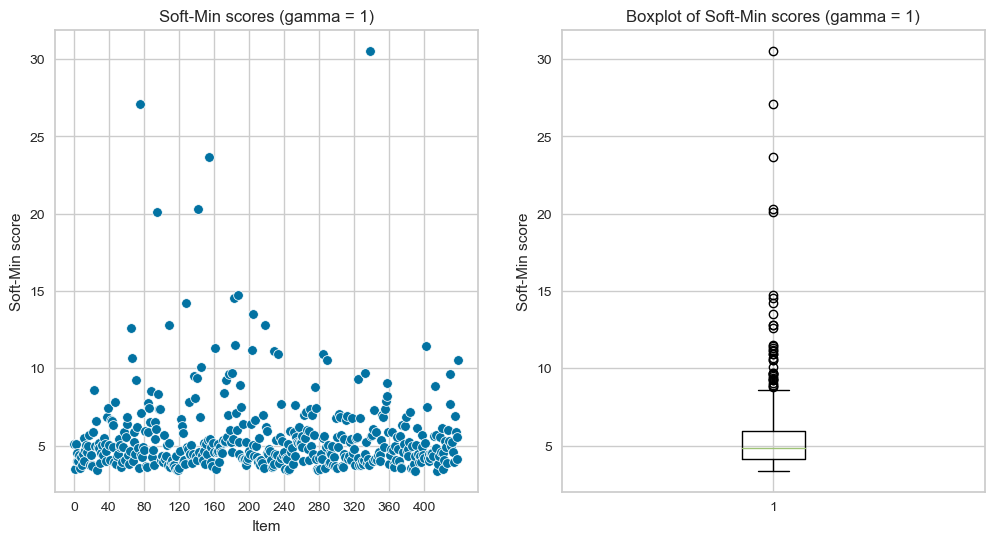

In [104]:
outliers = df_overview["outlier_score_softmin"]

min, max = p1_functions.plot_outliers(outliers)

# The scores are already computed for gamma = 1
outliers = df_overview["outlier_score_softmin"]

mask = outliers > 15
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

In [105]:
def relevance(x, yj, gamma):
    """Calculate layer-wise relevance propagation
    @x: array of instances
    @yj: softmin scores of all j instances
    @gamma: gamma used for softmin
    """

    Rji = np.zeros(x.shape)

    # calculation per instance
    for j in range(len(x)):

        # mask is used to exclude the current instance j
        mask = np.full((len(x)), True)
        mask[j] = False

        # save xk - xj
        xk_j = x - x[j]

        # calculate zk = ||xj - xk||^2
        zk = np.square(np.linalg.norm(xk_j, axis=1))

        # 1. First, one identifies to what extent each data point has contributed to the anomaly score of instance j
        temp = np.exp(-gamma * zk[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2. Then, these scores can be propagated back to the input features by observing that the (squared)
        # Euclidean distance entering the anomaly score can be decomposed in terms of individual components:
        Rji[j, :] = np.sum(np.square(xk_j)[mask] / zk[mask][:, None] * Rk[:, None], axis=0)

    return Rji


In [106]:
GAMMA = 1

# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin, 1, np.square(distances[:, 1:]), GAMMA)

x = df.to_numpy()
Rji = relevance(x, yj, GAMMA)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

True

/var/folders/_g/6x5zq2rd0vb_0cxd_jqx72dr0000gn/T/ipykernel_2158/1310147009.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  points = ax.scatter(x=X_embedded[:,1], y=X_embedded[:,0], c=yj, s=30, cmap=plt.cm.get_cmap('viridis_r'))


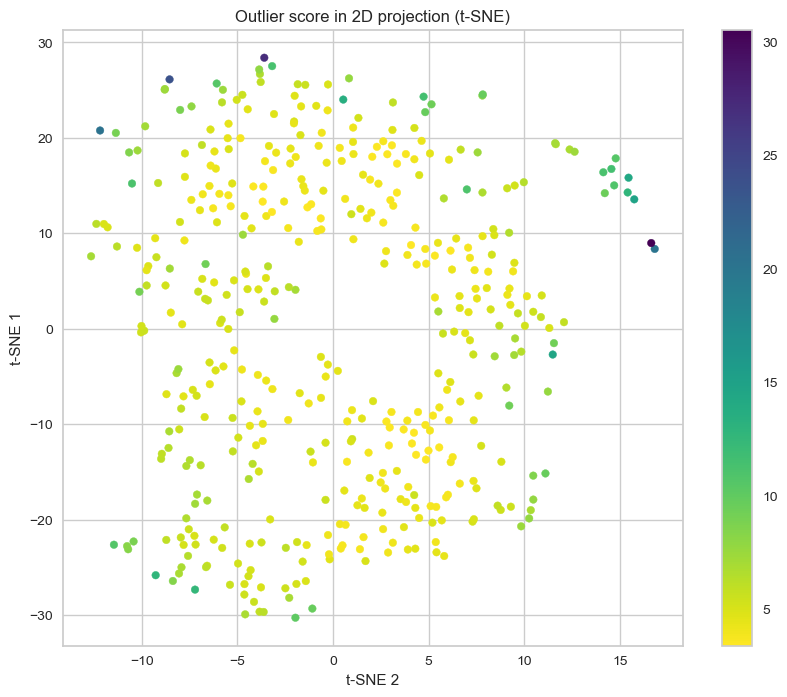

In [107]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

f, ax = plt.subplots(figsize=(10,8))
points = ax.scatter(x=X_embedded[:,1], y=X_embedded[:,0], c=yj, s=30, cmap=plt.cm.get_cmap('viridis_r'))
f.colorbar(points)
ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")
ax.set_title("Outlier score in 2D projection (t-SNE)")
plt.show()


# ***************** SUGGESTION FROM HERE *****************

## Reproducibility experiment for the explanations of the anomalies

### Inspection of gamma influence on the robustness of anomaly attribution scores

First, we perform a similar experiment as in Part 2.
For 100 bootstrap samples (n = 220) without replacement we compute the Soft-Min scores for 20 gamma values in the range [0.1, 2] and calculate the attribution to the outlierness of each feature.

In [108]:
# 50% random sample without replacement
# for each gamma:
#   calculate anomaly scores for sample instances
#   calculate relevance
#   save relevance (per component) for later analysis

N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

Rji_BS = np.full((440, N_BOOTSTRAP, len(gamma_range), 6), np.nan)

for i in range(N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])

    for k, g in enumerate(gamma_range):
        yj = np.apply_along_axis(softmin, 1, distances, g)
        Rji_BS[sample.index, i, k, :] = relevance(sample.to_numpy(), yj, g)

# for each instance, for each sample, for each gamma, the relevance per component
Rji_BS.shape

(440, 100, 20, 6)

#### Computation for all components at once

Since the range of the anomaly scores decreases for increasing gamma values, the range of the anomaly attribution scores is going to show the same trend. This makes comparison between different gamma values tricky.

To mitigate that, for each item we compute the mean and variance of Euclidean distances between the relevance of the components over all bootstrap samples. We repeat this computation for each gamma value.

We plot the resulting bootstrap sample statistics per each item and as mean over all items. dditionally, we colour the selected outliers in blue for visual inspection.

(440, 20)


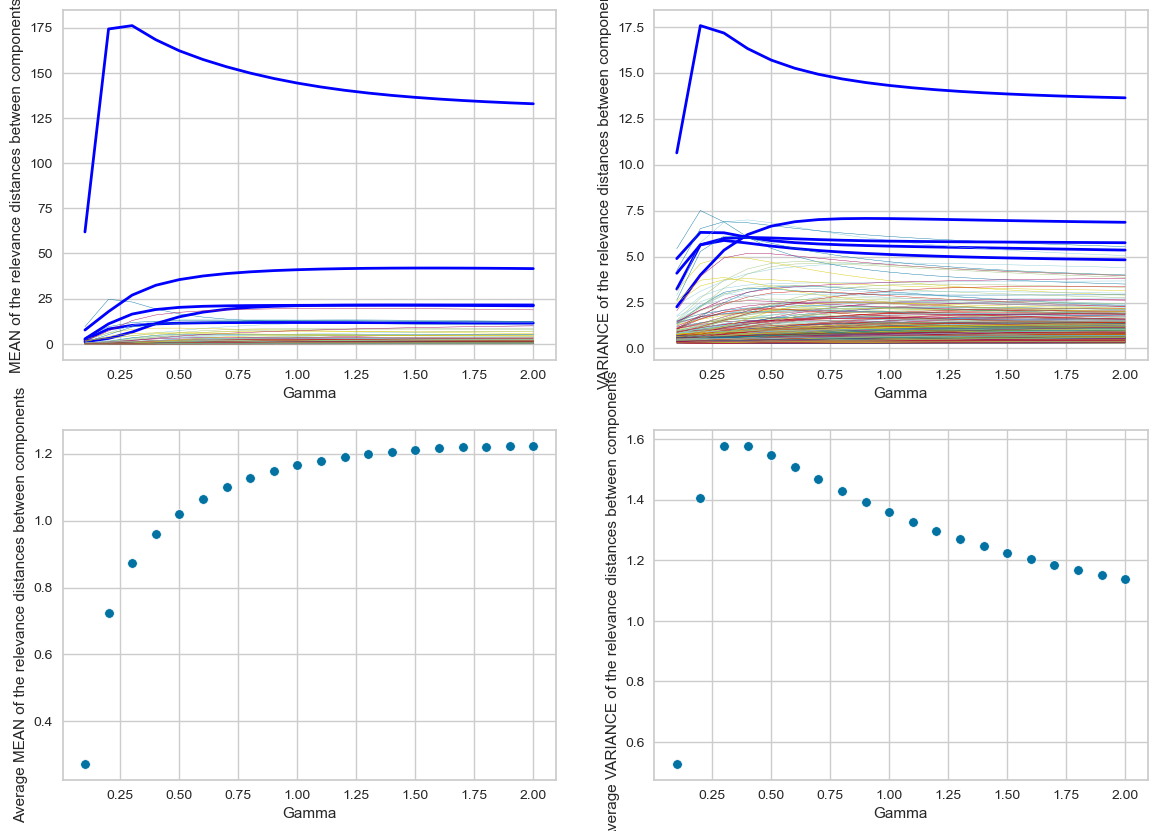

In [109]:
# Compute the mean and variance of Euclidean distances between the relevance of the components over all bootstrap samples (per instance, per gamma)

mean_dist = np.zeros((len(Rji_BS), len(gamma_range)))
var_dist = np.zeros((len(Rji_BS), len(gamma_range)))
print(mean_dist.shape)# (440, 20)

# iterate over instances
for item in range(len(Rji_BS)):
    # iterate over gammas
    for g in range(len(gamma_range)):
        #stats of pairwise distances between the 100 observations in 6-dim space
        mean_dist[item, g] = np.nanmean(distance.pdist(Rji_BS[item, :, g, :]))
        var_dist[item, g] = np.nanvar(distance.pdist(Rji_BS[item, :, g, :]))

p1_functions.distance_plots(mean_dist, var_dist, gamma_range, outliers_selected.array)

It can be seen that the outlier points tend to possess more distant component attribution values and these distances vary more.
The general trend is larger distances between component relevance  scores for higher gammas.
In terms of variance of the distances, it starts very low, peaks quickly and the slowly falls down.

#### Component-wise computations

For each item we calculate statistics of the anomaly attribution scores over each bootstrap sample. We compute this measure for all gammas. The statistics include mean, variance, and standard deviation.
We plot the values of the anomaly attribution mean and then variance per feature against the gamma values and mark the outliers in blue.

In [110]:
# Get the statistics over bootstraps
bootstrap_mean = np.nanmean(Rji_BS, axis=1) # all items mean over the boostraps for all gammas for all features
bootstrap_variance = np.nanvar(Rji_BS, axis=1) # all items variance over the boostraps for all gammas for all features
bootstrap_std = np.nanstd(Rji_BS, axis=1) # all items std over the boostraps for all gammas for all features

bootstrap_variance.shape

(440, 20, 6)

We plot the values of the anomaly attribution variances per feature against the gamma values and mark the outliers in blue.

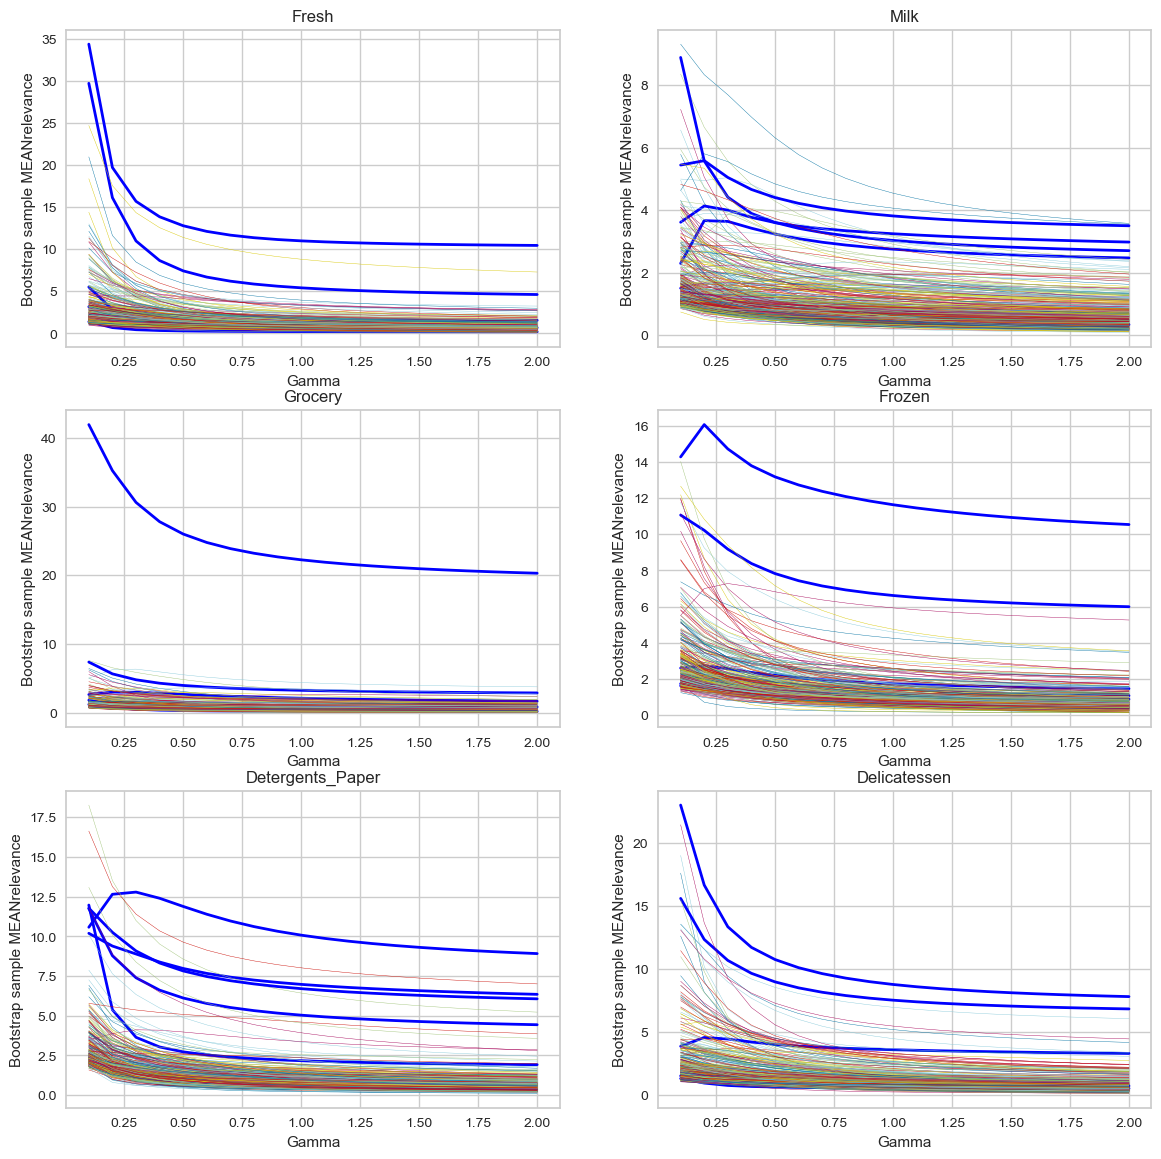

In [111]:
p1_functions.attribution_stat_plots(bootstrap_mean, gamma_range, num_features, outliers_selected.array, type = "MEAN")

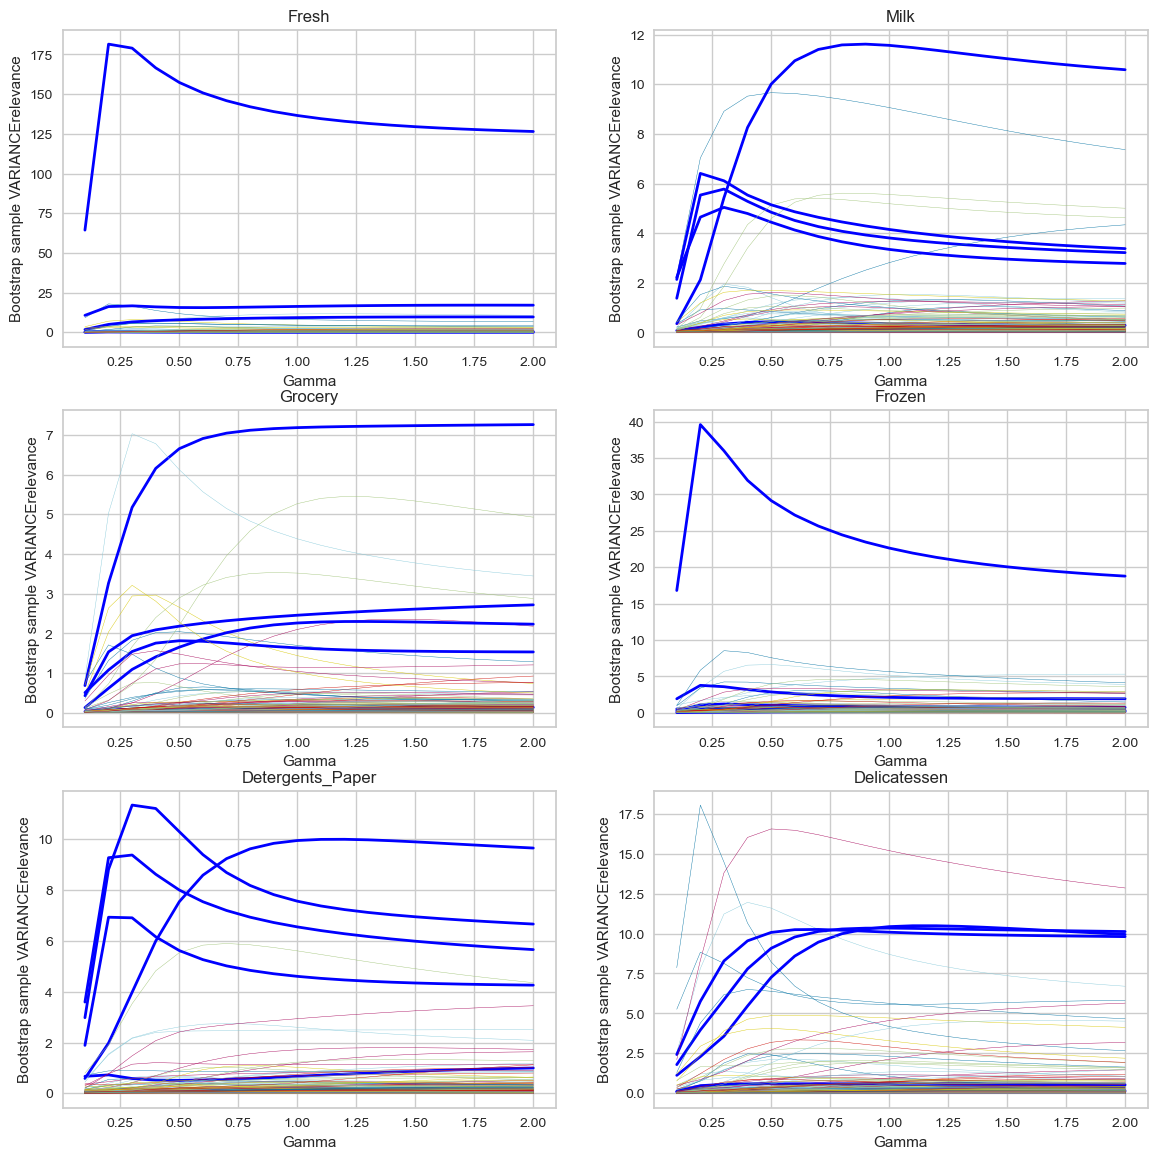

In [112]:
p1_functions.attribution_stat_plots(bootstrap_variance, gamma_range, num_features, outliers_selected.array, type = "VARIANCE")

It is visible from the plots that the highest values and the highest variation of the anomaly attribution scores is acquired by the outlier points.

We also computed the mean values of attribution variance for each feature. We plot these computations separately for inliers (all points but outliers) and outliers.

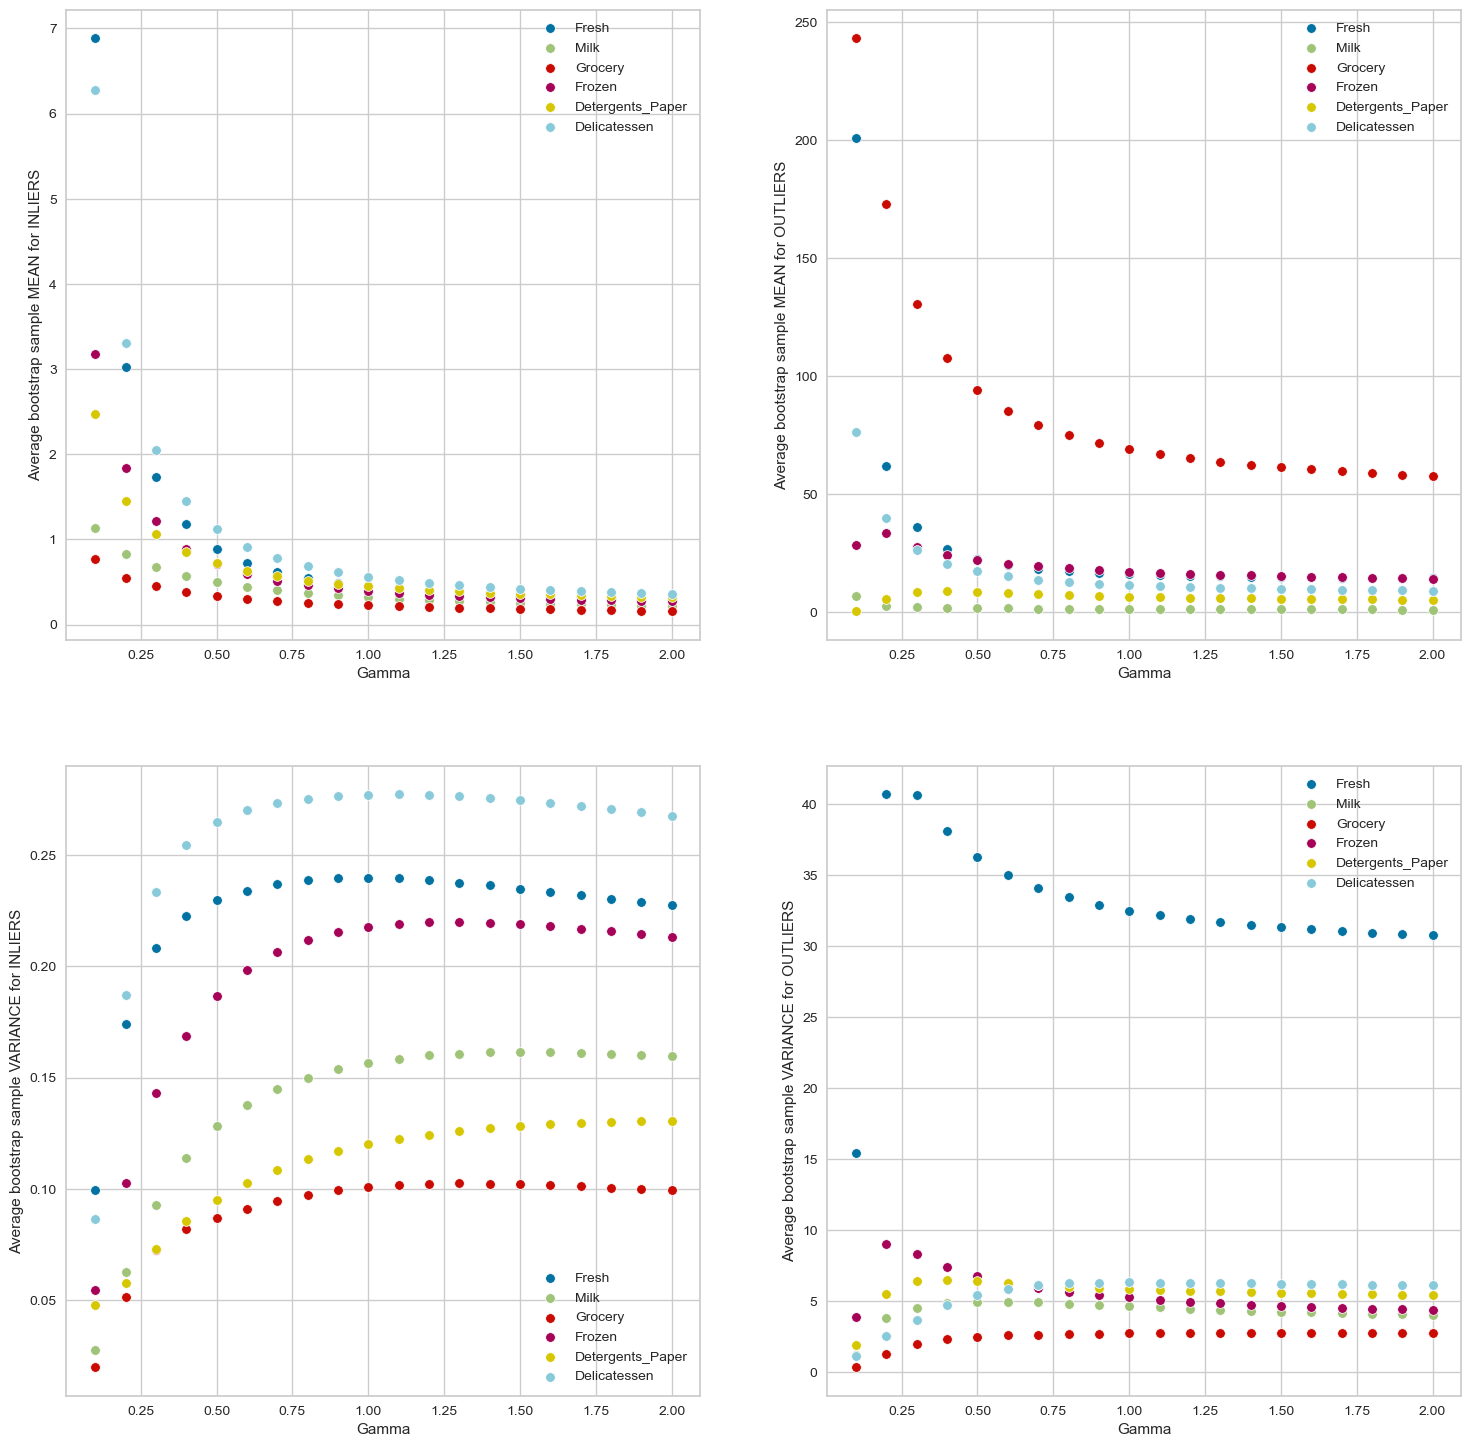

In [113]:
mask = outliers <= 15
inliers = outliers.argsort()[:sum(mask)]

from scipy import stats
#bootstrap_mean = (stats.zscore(bootstrap_mean, axis=0))
#bootstrap_variance = (stats.zscore(bootstrap_variance, axis=0))

p1_functions.attribution_variance_means(bootstrap_mean, bootstrap_variance, gamma_range, num_features, outliers_selected.array, inliers)

It can be observed that the statistics of the outlier points are in much larger ranges.
The range of the average variance for the inliers is especially narrow in comparison to that of the outliers. This implies that inlier variance is very low for all gammas, while it varies quite a lot for outliers.
Of course, this is not preferable, because we are mostly interested in robust estimate for outliers and not so much for the inliers.

 It is important to bear in mind that the ranges of the attribution scores differ per gamma. Could we apply some form of standardisation for better comparison?

### Inspection of the robustness of anomaly attribution scores for gamma = 1

In order to inspect the robustness for our chosen gamma = 1, we take into account the same statistics of the experiment above only for gamma = 1

In [114]:
# Get the index if gamma = 1 from the experiment
gamma_1_index = np.argwhere(np.around(gamma_range, 1) == 1)[0,0]

# Get the statistics over bootstraps for gamma = 1
bootstrap_mean_g1 = pd.DataFrame(bootstrap_mean[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1 = pd.DataFrame(bootstrap_variance[:,gamma_1_index,:], columns = num_features)
bootstrap_std_g1 = pd.DataFrame(bootstrap_std[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1.shape

(440, 6)

We compute boxplots with the mean and variance of the outlier attribution scores over the bootstrap samples.
For this computation we use 36 outlier instances since we are really interested in the robustness of the estimations for the outlier scores. We increased the number of outliers for more meaningful statistics.

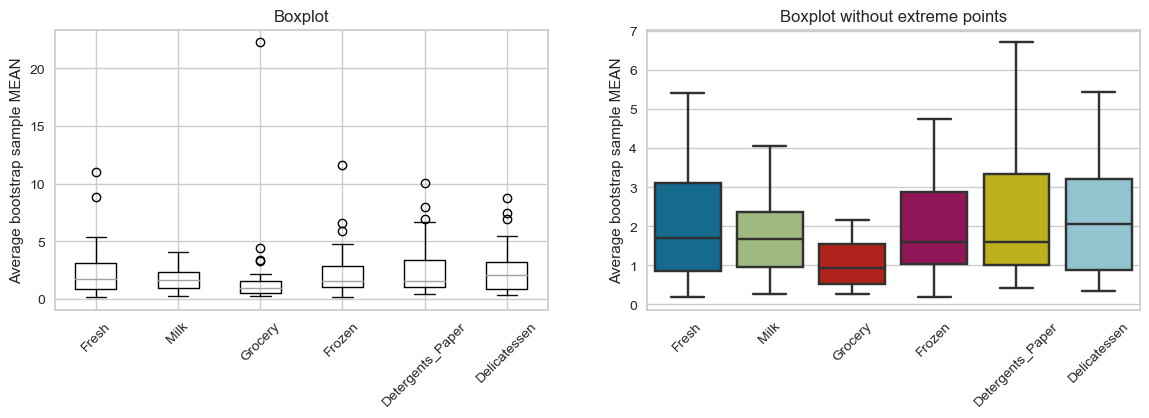

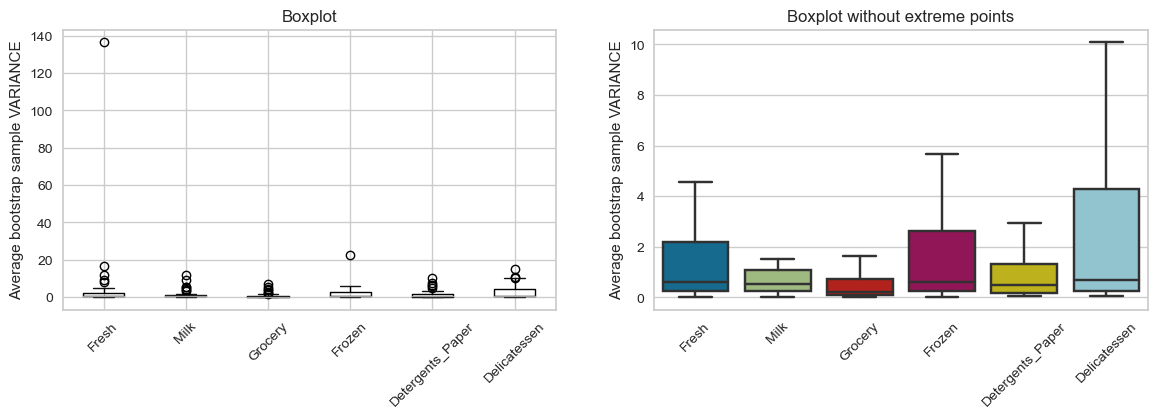

In [115]:
# The scores are already computed for gamma = 1
outliers = df_overview["outlier_score_softmin"]

mask = outliers > max
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

p1_functions.attribution_boxplots(bootstrap_mean_g1.iloc[outliers_selected, :], "MEAN")
p1_functions.attribution_boxplots(bootstrap_var_g1.iloc[outliers_selected, :], "VARIANCE")

We can observe that in both the mean and variance of the outlier attribution scores there are many outlier samples within this set of outliers throughout the components. This is not ideal.
At the same time, the sample variance medians are very low for all components which shows median tendency to robustness.
The median values at the means let us compare which components tend to be responsible for high outlierness. Grocery is the least contributing feature, while fresh and frozen produce as well as delicatessen are more likely contributors to high outlierness.


#### Inspection of accuracy
We want inspect the "accuracy" of the estimated relevance of each component by the Bootstrap experiment. For this, we use the relevance attribution scores computed for the whole dataset and compute product moment correlation

In [116]:
# Compare the "ground truth" attribution scores with the boostrap sample means
for i, feature in enumerate(num_features):
    corr, _ = stats.pearsonr(Rji[:,i], bootstrap_mean_g1.iloc[:,i])
    corr_outliers, _ = stats.pearsonr(Rji[outliers_selected,i], bootstrap_mean_g1.iloc[outliers_selected,i])
    print(f"{feature}: all data: {corr:.2} \n       outliers: {corr_outliers:.2}")

Fresh: all data: 0.75 
       outliers: 0.58
Milk: all data: 0.94 
       outliers: 0.81
Grocery: all data: 0.99 
       outliers: 0.99
Frozen: all data: 0.98 
       outliers: 0.98
Detergents_Paper: all data: 0.97 
       outliers: 0.95
Delicatessen: all data: 0.96 
       outliers: 0.93


#### Interpretability
We compare the attribution scores with data frame to see is the variation in the data explains the scores

In [117]:
# Compare the attribution scores with data frame to see is the variation in the data explains the scores
for i, feature in enumerate(num_features):
    corr, _ = stats.pearsonr(Rji[:,i], df.iloc[:,i])
    corr_og, _ = stats.pearsonr(Rji[:,i], df_og.iloc[:,i])
    print(f"{feature}: transformed data: {corr:.2} \n          original data: {corr_og:.2}")

Fresh: transformed data: -0.42 
          original data: -0.02
Milk: transformed data: -0.069 
          original data: 0.14
Grocery: transformed data: -0.3 
          original data: 0.004
Frozen: transformed data: -0.13 
          original data: 0.18
Detergents_Paper: transformed data: -0.35 
          original data: -0.11
Delicatessen: transformed data: -0.38 
          original data: 0.27


In [118]:
Rji[:,i]

array([ 0.58804525,  0.40497956,  2.43663495,  0.82918394,  1.05653714,
        0.56828876,  1.0067598 ,  0.69009718,  0.77007964,  0.7682052 ,
        0.5161685 ,  0.6234131 ,  1.03209519,  1.22134782,  0.68276586,
        0.37977763,  0.89493816,  1.39078496,  0.78307122,  0.88292515,
        0.47876571,  0.56565268,  0.80400372,  2.32549142,  1.78096905,
        0.83255074,  0.579258  ,  0.51901052,  1.49186902,  0.53317517,
        0.59700768,  0.57934161,  0.26689539,  0.89684919,  1.32263412,
        1.17858586,  1.13805496,  0.98779779,  3.22040626,  0.52166836,
        1.45795849,  0.51755504,  0.76887583,  2.42511845,  0.97008428,
        1.48154461,  0.65688429,  3.08576958,  0.53002088,  0.83201377,
        1.16969509,  1.19876743,  0.68597344,  1.10737752,  0.51120632,
        0.68533522,  0.80085993,  0.89009867,  0.6833245 ,  0.57150881,
        0.71788912,  1.40785262,  0.91110584,  0.86463741,  0.58908171,
        0.14849786,  5.83895379,  1.03256305,  1.15529118,  1.56

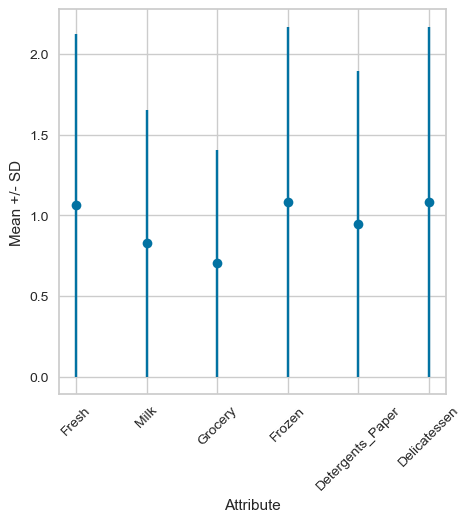

In [122]:
def means(array):
    fig = plt.figure(figsize=(5,5))
    mean = np.mean(bootstrap_mean_g1,axis=0)
    sd = np.mean(bootstrap_mean_g1,axis=0)

    plt.errorbar(num_features, mean, sd, marker='o', linestyle='None')
    plt.xlabel('Attribute')
    plt.ylabel('Mean +/- SD')
    plt.xticks(rotation=45)
    #fig.suptitle("")
    plt.show()

means(Rji_BS)